In [47]:
from ngsolve import *

In [48]:
import netgen.gui

In [49]:
from netgen.geom2d import unit_square
import matplotlib.pyplot as plt
import numpy as np
import time

In [50]:
# set order of method
orderP = 1
# adaptive parameter theta=1 equals uniform refinement 
theta = 0.25;
# set max dofs (if numer of dofs is larger than maxDOFs, then computation ends after that step)
maxDOFs = 50000

In [51]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.25))
Draw(mesh);

 Generate Mesh from spline geometry


In [52]:
## Example 1: Known solution
# Exact solution of problem
ExampleName = "Example1"
exactSolKnown = True
vEx = y*sin(pi*x)
sigmaEx = y*y/2*pi*cos(pi*x)
# data
f = sin(pi*x)+pi*pi*y*y/2*sin(pi*x)
g = 0
v0 = 0
sigma0 = 0

## Example2: Gaussian pulse, exact solution not known
ExampleName = "Example2"
exactSolKnown = False
kappa = 1000
mu = 0.2
v0 = 2*kappa*(x-mu)*exp(-kappa*(x-mu)*(x-mu))
sigma0 = -2*kappa*(x-mu)*exp(-kappa*(x-mu)*(x-mu))
f = 0
g = 0

## Example3: Solution with jumps.
ExampleName = "Example3"
exactSolKnown = False
v0 = 1
sigma0 = 0
f = 0
g = 0

In [53]:
# Set filename were basic information (number of dofs, error estimator) are storedd
fNAMEresults = ExampleName + "_orderP" + str(orderP) + "_maxDof" + str(maxDOFs) + "_theta" + str(theta)
fNAMEresults = fNAMEresults + ".csv"

In [54]:
# Define FEM spaces
V = H1(mesh, order=orderP, dirichlet="left|right")
SIGMA = H1(mesh, order=orderP)

fesm = V*SIGMA

In [55]:
# Define functions v,sigma and test functions w,tau
v,sigma = fesm.TrialFunction()
w,tau = fesm.TestFunction()

In [56]:
# Define and assemble bilinear form
blf = BilinearForm(fesm)
blf+= ( (grad(v)[1]-grad(sigma)[0])*(grad(w)[1]-grad(tau)[0])  )*dx
blf+= ( (grad(sigma)[1]-grad(v)[0])*(grad(tau)[1]-grad(w)[0])  )*dx

# add boundary terms
blf+= ( v*w + sigma*tau )*ds("bottom")

# Assemble
blf.Assemble()

In [57]:
# Define Linear form
rhs = LinearForm(fesm)
rhs+= (f*(grad(w)[1]-grad(tau)[0]) + g*(grad(tau)[1]-grad(w)[0]))*dx
rhs+= ( v0*w + sigma0*tau )*ds("bottom")

rhs.Assemble()

In [58]:
# grid function
gfm = GridFunction(fesm)
gfv, gfsigma = gfm.components

In [59]:
#Define boundary2elements mapping
def GetB2E():
    #start = time.time()
   
    f2eAUX = np.zeros(mesh.nedge,dtype=int)
    
    for el in mesh.Elements(VOL):
        f2eAUX[el.edges[0].nr] = el.nr
        f2eAUX[el.edges[1].nr] = el.nr
        f2eAUX[el.edges[2].nr] = el.nr
    
    nrBND = 0;
    for el in mesh.Elements(BND):
        nrBND += 1
    
    b2e = np.zeros(nrBND,dtype=int)
    
    
    for el in mesh.Elements(BND):
        b2e[el.nr] = f2eAUX[el.edges[0].nr]
    
    
    #end = time.time()
    #print("    Computing took ", (end - start), " seconds")
    return b2e

In [60]:
errVol = (grad(gfv)[1]-grad(gfsigma)[0]-f)*(grad(gfv)[1]-grad(gfsigma)[0]-f)
errVol += (grad(gfsigma)[1]-grad(gfv)[0]-g)*(grad(gfsigma)[1]-grad(gfv)[0]-g)
eta2 = Integrate(errVol, mesh, VOL, element_wise=True)

In [61]:
# realization of doerfler marking
def MarkBulk(eta,theta):
    indicators_sorted=np.sort(eta.NumPy())
    indicators_sorted[::-1] = indicators_sorted
    idx=np.argsort(eta.NumPy())
    idx[::-1]=idx

    

    sumind = np.cumsum(indicators_sorted)

    
    tmp = sumind>=sumind[len(sumind)-1]*theta
    jdx = np.min(np.where(tmp==True))

    
    
    marked = idx[0:jdx+1]
    #print(np.arange(0,jdx+1))
    #print(marked)

    tmp = np.full(len(eta.NumPy()), False)
    tmp[marked] = True
    #print(tmp)
    return tmp



In [62]:
def SolveBVP():
    fesm.Update()
    gfm.Update()
    gfv.Update()
    gfsigma.Update()
    blf.Assemble()
    rhs.Assemble()
    gfm.vec.data = blf.mat.Inverse(freedofs=fesm.FreeDofs(), inverse="umfpack") * rhs.vec.data
    Draw(gfv)
    Redraw (blocking=True)

In [63]:
l = []    # l = list of estimated total error
errExact = [] # if exact solution is known

def CalcError():

    # compute estimator:
    gfm.Update()
    gfv.Update()
    gfsigma.Update()

    errVol = (grad(gfv)[1]-grad(gfsigma)[0]-f)*(grad(gfv)[1]-grad(gfsigma)[0]-f)
    errVol += (grad(gfsigma)[1]-grad(gfv)[0]-g)*(grad(gfsigma)[1]-grad(gfv)[0]-g)
    eta2 = Integrate(errVol, mesh, VOL, element_wise=True)
    
    #print(maxerr)

    # boundary errors
    errBou2 = Integrate((gfv-v0)*(gfv-v0),mesh,BND,element_wise=True,definedon=mesh.Boundaries("bottom"))
    errBou2+= Integrate((gfsigma-sigma0)*(gfsigma-sigma0),mesh,BND,element_wise=True,definedon=mesh.Boundaries("bottom"))
    tmp = eta2.NumPy()
    b2e = GetB2E() # compute boundary to volume element relation
    tmp[b2e] = tmp[b2e] + errBou2 # update error estimator (this adds directly to eta2)
    
    
    if(theta<1):
        mesh.ngmesh.Elements2D().NumPy()["refine"] = MarkBulk(eta2,theta)
    

    l.append ((fesm.ndof, sqrt(sum(eta2))))
    print("ndof =", fesm.ndof, " ErrEst =", sqrt(sum(eta2)))


    if(exactSolKnown == True):
        tmp = (vEx-gfv)*(vEx-gfv)+(sigmaEx-gfsigma)*(sigmaEx-gfsigma)
        tmp+= (grad(gfv)[1]-grad(gfsigma)[0]-f)*(grad(gfv)[1]-grad(gfsigma)[0]-f)
        tmp+= (grad(gfsigma)[1]-grad(gfv)[0]-g)*(grad(gfsigma)[1]-grad(gfv)[0]-g)
        
        errTMP = Integrate( tmp, mesh, VOL,element_wise=True)
        errExact.append( (fesm.ndof,sqrt(sum(errTMP))))

In [64]:
while fesm.ndof < maxDOFs:
    SolveBVP()
    CalcError()
    mesh.Refine()

ndof = 52  ErrEst = 0.596170937860841
 Mesh bisection
 Bisection done
ndof = 62  ErrEst = 0.5256494638693423
 Mesh bisection
 Bisection done
ndof = 72  ErrEst = 0.5222140283957712
 Mesh bisection
 Bisection done
ndof = 84  ErrEst = 0.5211722416518239
 Mesh bisection
 Bisection done
ndof = 104  ErrEst = 0.6143932347750809
 Mesh bisection
 Bisection done
ndof = 112  ErrEst = 0.6090814001279772
 Mesh bisection
 Bisection done
ndof = 132  ErrEst = 0.6070208916548084
 Mesh bisection
 Bisection done
ndof = 158  ErrEst = 0.5923997669514112
 Mesh bisection
 Bisection done
ndof = 206  ErrEst = 0.5915223396502512
 Mesh bisection
 Bisection done
ndof = 270  ErrEst = 0.5490472915482463
 Mesh bisection
 Bisection done
ndof = 342  ErrEst = 0.5094100955846086
 Mesh bisection
 Bisection done
ndof = 420  ErrEst = 0.4982246700977137
 Mesh bisection
 Bisection done
ndof = 526  ErrEst = 0.49425204151788515
 Mesh bisection
 Bisection done
ndof = 658  ErrEst = 0.4941848382527148
 Mesh bisection
 Bisection d

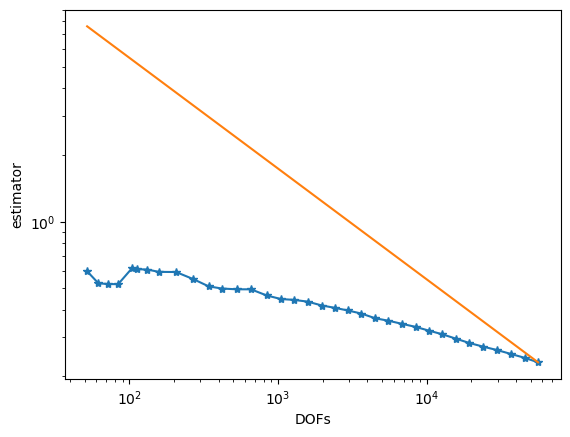

In [65]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("DOFs")
plt.ylabel("estimator")
ndof,err = zip(*l)
hp = np.power(sqrt(np.divide(1,ndof)*ndof[-1]),orderP)*err[-1]
plt.plot(ndof,err, "-*",ndof,hp)

plt.ion()
plt.show()

In [66]:
if(exactSolKnown == True):
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("DOFs")
    plt.ylabel("error")
    ndof,est = zip(*l)
    ndof,err = zip(*errExact)
    hp = np.power(sqrt(np.divide(1,ndof)*ndof[-1]),orderP)*err[-1]
    plt.plot(ndof,est, "-*",ndof,hp,ndof,err)
    
    plt.ion()
    plt.show()

In [67]:
## save data (estimator and error) to csv file, for postprocessing 
#np.savetxt(fNAMEresults, l, delimiter=',', header="ndof,errEst", comments="")


In [68]:
# Update draw and possible store result for visualization
gfm.Update()
gfv.Update()
gfsigma.Update()
Redraw()

## VTKOutput object
vtk = VTKOutput(ma=mesh,
                coefs=[gfv,gfsigma],
                names = ["v","sigma"],
                filename=ExampleName+"_orderP" + str(orderP) + "_maxDOFs" + str(maxDOFs),
                subdivision=orderP-1)
# Exporting results:
vtk.Do()

'Example3_orderP1_maxDOFs50000'

In [69]:
ndof

(52,
 62,
 72,
 84,
 104,
 112,
 132,
 158,
 206,
 270,
 342,
 420,
 526,
 658,
 838,
 1048,
 1274,
 1580,
 1980,
 2404,
 2950,
 3628,
 4518,
 5536,
 6804,
 8416,
 10346,
 12720,
 15846,
 19344,
 24072,
 29742,
 36880,
 45710,
 56160)